In [1]:
import numpy as np
from osgeo import gdal, osr
from tqdm import tqdm, trange
import torch
import matplotlib.pyplot as plt

from esd_quantizer import Quantizer

In [2]:
tile_name = "36RUU"

dtset = gdal.Open(f"./SDC30_EBD_V001_{tile_name}_2000.tif")
ESD_codes1 = dtset.ReadAsArray()
dtset = None;    del dtset
_, H, W = ESD_codes1.shape ## (12 temporal steps + 1 QA band, Height, Width)

print(ESD_codes1.shape, ESD_codes1.dtype)

dtset = gdal.Open(f"./SDC30_EBD_V001_{tile_name}_2024.tif")
ESD_codes2 = dtset.ReadAsArray()
dtset = None;    del dtset

print(ESD_codes2.shape, ESD_codes2.dtype)

(13, 3600, 3600) uint16
(13, 3600, 3600) uint16


# 1. Convert ESD codes to vectors

In [3]:
quantizer = Quantizer()
quantizer.load_state_dict(torch.load("ESD_quantizer.pth"))

ESD_vectors1 = np.empty([12, 6, H, W], dtype=np.float32)
for ir in trange(H):
    with torch.no_grad():
        quantized = quantizer.indices_to_codes(torch.from_numpy(ESD_codes1[:12, ir, :].astype(np.int32)))
        quantized = quantized.permute([0,2,1])
        ESD_vectors1[:, :, ir, :] = quantized[:, :, :].cpu().numpy()
        
ESD_vectors2 = np.empty([12, 6, H, W], dtype=np.float32)
for ir in trange(H):
    with torch.no_grad():
        quantized = quantizer.indices_to_codes(torch.from_numpy(ESD_codes2[:12, ir, :].astype(np.int32)))
        quantized = quantized.permute([0,2,1])
        ESD_vectors2[:, :, ir, :] = quantized[:, :, :].cpu().numpy()

ESD_vectors1.shape, ESD_vectors2.shape  ## (months, channels, height, width)

100%|█████████████████████████████████████████████████████████████████████████████| 3600/3600 [00:03<00:00, 1033.37it/s]


((12, 6, 3600, 3600), (12, 6, 3600, 3600))

Text(0.5, 1.0, 'ESD in 2024')

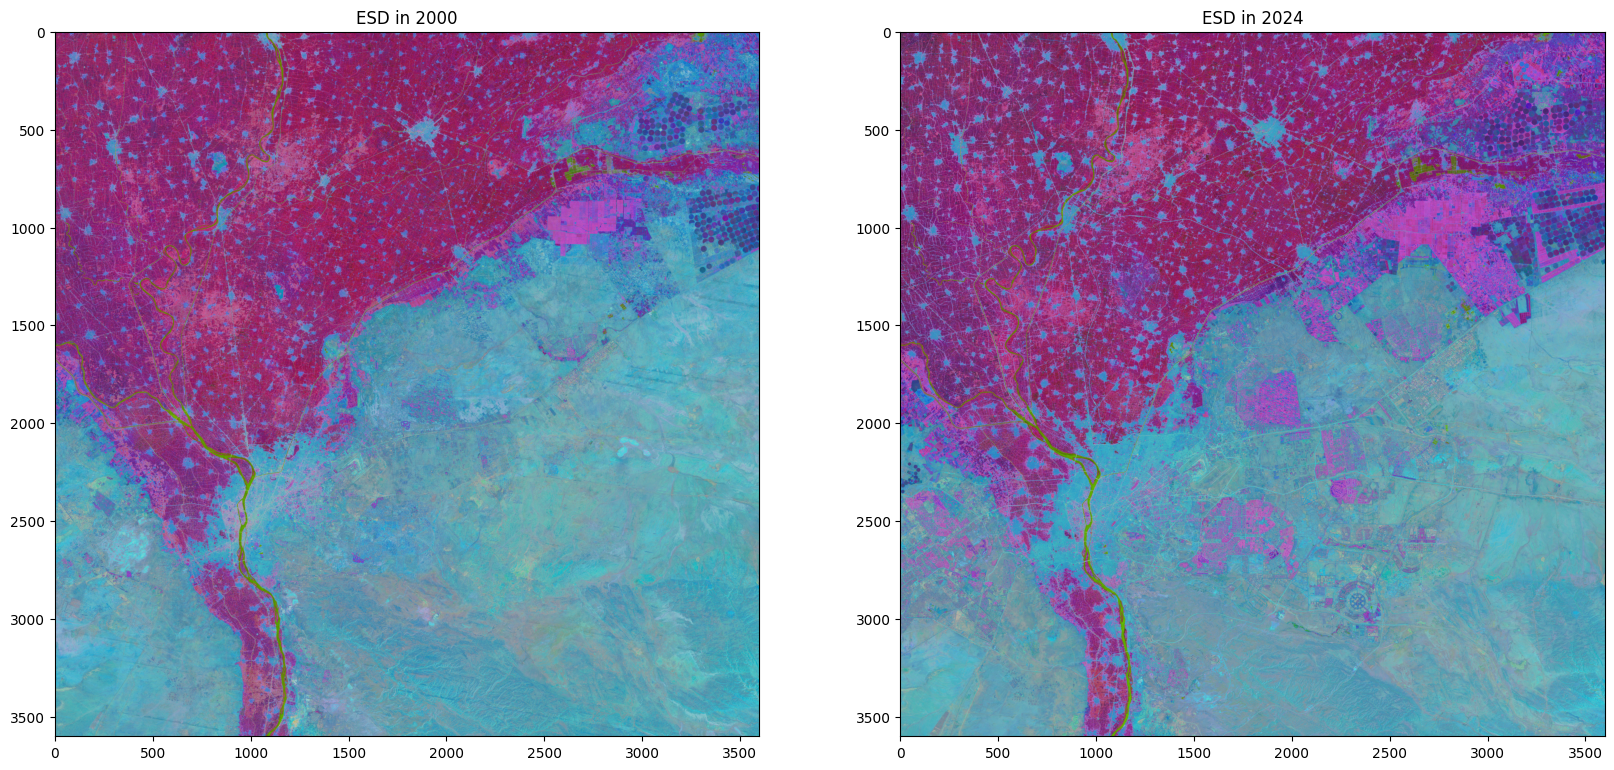

In [4]:
def ESD2IMG(codes, vectors):
    valid_mask = ~np.all(codes[:12] == 0, axis=0)
    # Convert to RGB image
    disp_img = np.zeros([3600, 3600, 4], dtype=np.uint8)  # RGBA
    disp_img[:, :, 0] = (np.mean(vectors[:, 5], axis=0) + 1) / 2 * 255
    disp_img[:, :, 1] = (np.mean(vectors[:, 1], axis=0) + 1) / 2 * 255
    disp_img[:, :, 2] = (np.mean(vectors[:, 2], axis=0) + 1) / 2 * 255
    # Mask areas without valid ESD data
    disp_img[:, :, 3] = np.where(valid_mask, 255, 0).astype(np.uint8)
    return disp_img


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].imshow(ESD2IMG(ESD_codes1, ESD_vectors1))
axes[1].imshow(ESD2IMG(ESD_codes2, ESD_vectors2))

axes[0].set_title("ESD in 2000")
axes[1].set_title("ESD in 2024")

# 2. Change detection by differencing the embedding vectors

In [5]:
from numba import prange, jit

@jit(nopython=True, fastmath=True, cache=True, parallel=True)
def EBD_cossim(SDC30_EBD_ref0, SDC30_EBD_ref1):
    N, C, H, W = SDC30_EBD_ref0.shape
    similarity_matrix = np.zeros((H, W), dtype=np.float32)
    for ir in prange(H):
        for ic in range(W):
            embedding0 = SDC30_EBD_ref0[:, :, ir, ic].flatten()
            embedding1 = SDC30_EBD_ref1[:, :, ir, ic].flatten()
            
            similarity_matrix[ir, ic] = np.dot(embedding0, embedding1) / (np.linalg.norm(embedding0) * np.linalg.norm(embedding1))
    return similarity_matrix

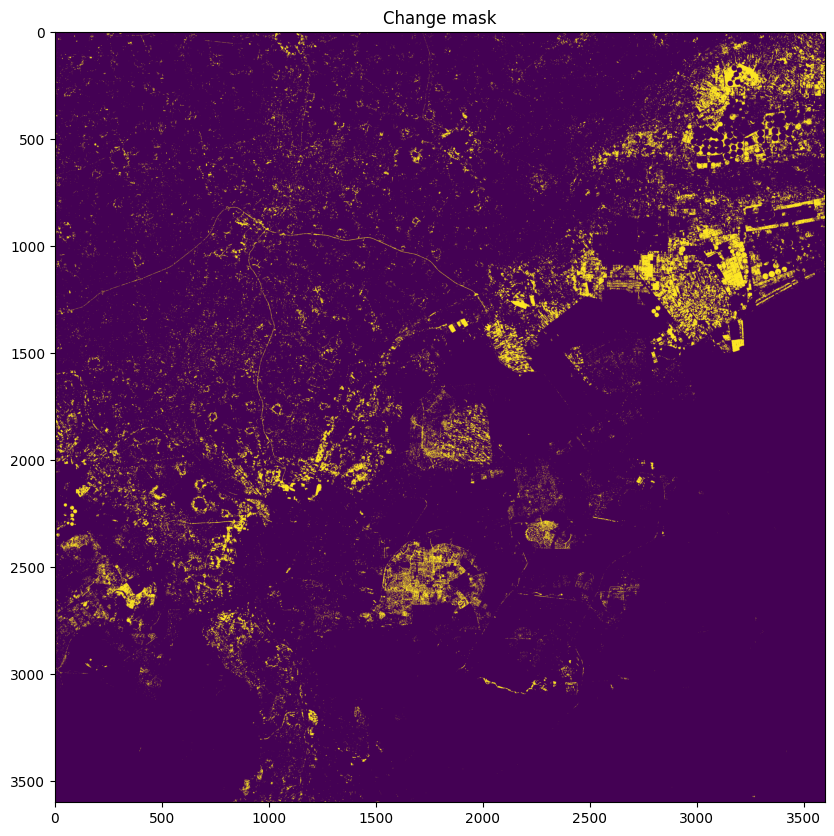

In [6]:
sim_mat = EBD_cossim(ESD_vectors1, ESD_vectors2)

plt.figure(figsize=(10, 10))
plt.title("Change mask")
plt.imshow(sim_mat < 0.2)